In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import lib

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report

Import Dataset

In [116]:
test = pd.read_csv("/content/drive/MyDrive/Data Science/Kaggle Competition/Spaceship_titanic/test.csv")
train = pd.read_csv("/content/drive/MyDrive/Data Science/Kaggle Competition/Spaceship_titanic/train.csv")
# print(test.info())
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


In [117]:
missing_train = train.isnull().sum()
missing_test = test.isnull().sum()

print("Percentage Missing train data\n",train.isnull().mean() * 100,)
print("="*20)
print("Percentage Missing of test data\n", test.isnull().mean() * 100)
# print(missing_train)
# print(missing_test)



# Vẽ heatmap cho dữ liệu bị thiếu|
# plt.figure(figsize=(12, 8))
# sns.heatmap(train.isnull(), cbar=False, cmap='viridis', yticklabels=False)
# plt.title('Visualization of Missing Data')
# plt.show()

Percentage Missing train data
 PassengerId    0.00
HomePlanet     2.31
CryoSleep      2.50
Cabin          2.29
Destination    2.09
Age            2.06
VIP            2.34
RoomService    2.08
FoodCourt      2.11
ShoppingMall   2.39
Spa            2.11
VRDeck         2.16
Name           2.30
Transported    0.00
dtype: float64
Percentage Missing of test data
 PassengerId    0.00
HomePlanet     2.03
CryoSleep      2.17
Cabin          2.34
Destination    2.15
Age            2.13
VIP            2.17
RoomService    1.92
FoodCourt      2.48
ShoppingMall   2.29
Spa            2.36
VRDeck         1.87
Name           2.20
dtype: float64


# Checking balanced data or not

In [118]:
class_counts = train['Transported'].value_counts()
print(class_counts)

True     4378
False    4315
Name: Transported, dtype: int64


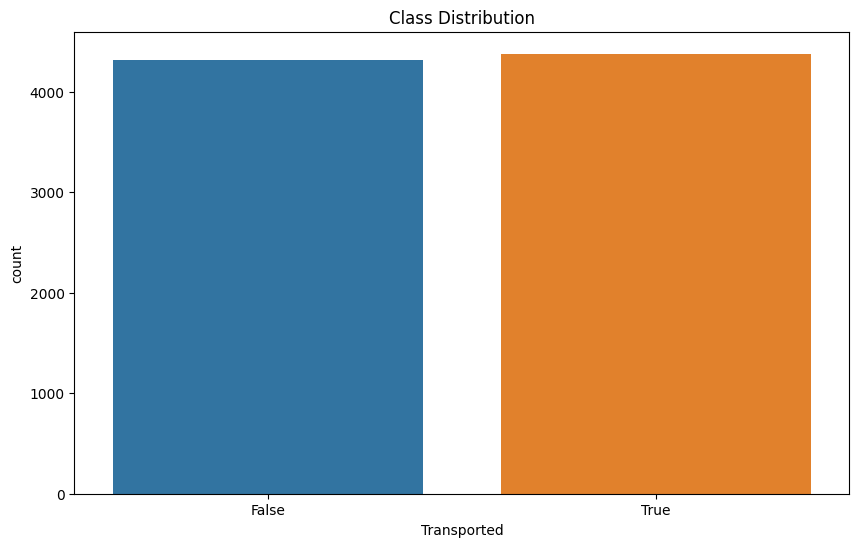

In [119]:
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='Transported')
plt.title('Class Distribution')
plt.show()


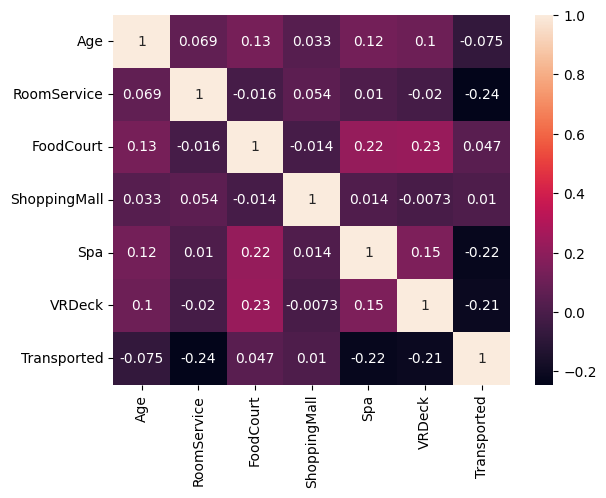

In [120]:
sns.heatmap(train.corr(), annot=True)
plt.show()

Biểu đồ corr yếu nên khả năng cao xài model tuyến tính sẽ cho kết quả không được tốt

In [144]:
target = 'Transported'
x = train.drop([target, "PassengerId", "Name", "Cabin"], axis = 1)
y = train[target]

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
print(y_train.shape)
print(X_train.shape)


(6954,)
(6954, 10)


#Pipeline:
- Preprocessing
- Imputer
- Transformer

In [122]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])


In [123]:
print((X_train["HomePlanet"].unique()))
print((X_train["Destination"].unique()))
print((X_train["VIP"].unique()))


['Earth' 'Europa' 'Mars' nan]
['TRAPPIST-1e' '55 Cancri e' 'PSO J318.5-22' nan]
[False True nan]


In [124]:
# HomePlanet_vals = ['Earth','Europa','Mars']
# CryoSleep_vals = X_train["CryoSleep"].unique()
# Destination_vals = X_train["Destination"].unique()
# VIP_vals = X_train["VIP"].unique()

HomePlanet_vals = ['Earth','Europa','Mars']
CryoSleep_vals = X_train["CryoSleep"].dropna().unique().tolist()
Destination_vals = X_train["Destination"].dropna().unique().tolist()
VIP_vals = X_train["VIP"].dropna().unique().tolist()
print(HomePlanet_vals)
print(CryoSleep_vals)
print(Destination_vals)
print(VIP_vals )

['Earth', 'Europa', 'Mars']
[False, True]
['TRAPPIST-1e', '55 Cancri e', 'PSO J318.5-22']
[False, True]


In [125]:
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),  # Xử lý missing value
    # ('scaler', OrdinalEncoder(categories=[HomePlanet_vals, X_train["CryoSleep"].unique(), X_train["Destination"].unique(), X_train["VIP"].unique()]))
    ('scaler', OrdinalEncoder(categories=[CryoSleep_vals , VIP_vals]))    # Biến đổi dữ liệu
])

In [126]:
norminal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy="most_frequent")),  # Xử lý missing value
    ('scaler', OneHotEncoder())  # Biến đổi dữ liệu
])

# Preprocessor

In [127]:
preprocessor =  ColumnTransformer(transformers=[
    ("num_features",numerical_transformer, ["Age", 'RoomService','FoodCourt', 'ShoppingMall','Spa','VRDeck']),
    ('ord_features',ordinal_transformer, ["CryoSleep",'VIP']),
    ('nom_features',norminal_transformer, ['HomePlanet', 'Destination'])
])

#pipeline

In [135]:
cls_lazy = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # ('model', RandomForestRegressor())
])

# LazyPredict

In [136]:
X_train = cls_lazy.fit_transform((X_train))
X_test = cls_lazy.transform(X_test)
clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
print(models)

100%|██████████| 29/29 [00:30<00:00,  1.04s/it]

[LightGBM] [Info] Number of positive: 3500, number of negative: 3454
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1378
[LightGBM] [Info] Number of data points in the train set: 6954, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503307 -> initscore=0.013230
[LightGBM] [Info] Start training from score 0.013230
                               Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
XGBClassifier                      0.79               0.79     0.79      0.79   
LGBMClassifier                     0.79               0.79     0.79      0.79   
SGDClassifier                      0.78               0.78     0.78      0.78   
SVC                                0.78

# GridSearch

In [ ]:
# Logistic Regression
# LGBMClassifier
# RandomForestClassifier

In [156]:
cls = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression())
    # ('model', RandomForestClassifier())

])

In [141]:
# Logistic regression parameters
lr_params = {
    "model__penalty":['l1', 'l2', 'elasticnet', None],
    "model__solver":['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
}

In [142]:
#  RandomForestClassifier parameters
rf_params = {
    "model__criterion": ["gini", "entropy", "log_loss"],
    "model__max_features": ["sqrt", "log2", None],
}

In [157]:
grid_cls = GridSearchCV(cls, param_grid=lr_params, cv = 6, verbose=2)
grid_cls.fit(X_train, y_train)
y_predict = grid_cls.predict(X_test)
print(classification_report(y_test, y_predict))


Fitting 6 folds for each of 24 candidates, totalling 144 fits
[CV] END .............model__penalty=l1, model__solver=lbfgs; total time=   0.0s
[CV] END .............model__penalty=l1, model__solver=lbfgs; total time=   0.0s
[CV] END .............model__penalty=l1, model__solver=lbfgs; total time=   0.0s
[CV] END .............model__penalty=l1, model__solver=lbfgs; total time=   0.0s
[CV] END .............model__penalty=l1, model__solver=lbfgs; total time=   0.0s
[CV] END .............model__penalty=l1, model__solver=lbfgs; total time=   0.0s
[CV] END .........model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END .........model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END .........model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END .........model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END .........model__penalty=l1, model__solver=liblinear; total time=   0.1s
[CV] END .........model__penalty=l1, model__sol

In [158]:
submission_pred=grid_cls.predict(test)

In [159]:
submission_pred.shape

(4277,)

In [161]:
test_ids=test['PassengerId']
test_ids.shape

(4277,)

In [162]:
submission_pred=submission_pred.astype(bool)

In [163]:
df=pd.DataFrame({'PassengerId':test_ids.values,'Transported':submission_pred})

In [165]:
df.to_csv("/content/drive/MyDrive/Data Science/Kaggle Competition/Spaceship_titanic/Submission.csv",index=False)